In [1]:
__author__ = 'tan_nguyen'

import os
import time

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Import Tensorflow and start a session
import tensorflow as tf
sess = tf.InteractiveSession()



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


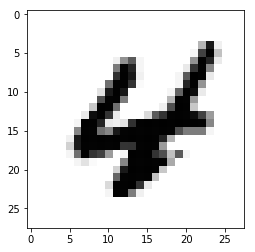

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

In [ ]:


def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''
    # IMPLEMENT YOUR WEIGHT_VARIABLE HERE
    initial_W = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial_W)

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''

    # IMPLEMENT YOUR BIAS_VARIABLE HERE
    initial_b = tf.constant(0.1, shape=shape)
    return tf.Variable(initial_b)

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''

    # IMPLEMENT YOUR CONV2D HERE
    h_conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return h_conv

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''

    # IMPLEMENT YOUR MAX_POOL_2X2 HERE
    h_max = tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    return h_max


# Specify training parameters
result_dir = './results/' # directory where the results from the training are saved
max_step = 3000 # the maximum iterations. After max_step iterations, the training will stop no matter what

start_time = time.time() # start timing

# FILL IN THE CODE BELOW TO BUILD YOUR NETWORK

# placeholders for input data and input labeles
x       = tf.placeholder(tf.float32, shape=[None, 784])
y_      = tf.placeholder(tf.float32, shape=[None, 10])


# reshape the input image
x_image = tf.reshape(x, [-1, 28, 28, 1])

# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout
keep_prob  = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# softmax
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# FILL IN THE FOLLOWING CODE TO SET UP THE TRAINING

# setup training
cross_entropy = tf.reduce_mean(
tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Add a scalar summary for the snapshot loss.
#tf.summary.scalar(cross_entropy.op.name, cross_entropy)
# Build the summary operation based on the TF collection of Summaries.
#summary_op = tf.summary.merge_all()

# Add the variable initializer Op.
init = tf.global_variables_initializer()

# Create a saver for writing training checkpoints.
#saver = tf.train.Saver()

# Instantiate a SummaryWriter to output summaries and the Graph.
#summary_writer = tf.summary.FileWriter(result_dir, sess.graph)

# Run the Op to initialize the variables.
sess.run(init)

# run the training
for i in range(max_step):
    batch = mnist.train.next_batch(50) # make the data batch, which is used in the training iteration.
                                        # the batch size is 50
    if i%100 == 0:
        # output the training accuracy every 100 iterations
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_:batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

        # Update the events file which is used to monitor the training (in this case,
        # only the training loss is monitored)
        #summary_str = sess.run(summary_op, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        #summary_writer.add_summary(summary_str, i)
        #summary_writer.flush()

    # save the checkpoints every 1100 iterations
    #if i % 1100 == 0 or i == max_step:
        #checkpoint_file = os.path.join(result_dir, 'checkpoint')
        #saver.save(sess, checkpoint_file, global_step=i)

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5}) # run one train_step

# print test error
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

stop_time = time.time()
print('The training takes %f second to finish'%(stop_time - start_time))



step 0, training accuracy 0.06
step 100, training accuracy 0.84
step 200, training accuracy 0.9
step 300, training accuracy 0.96
step 400, training accuracy 0.88
step 500, training accuracy 0.94
step 600, training accuracy 0.9
step 700, training accuracy 0.9
step 800, training accuracy 0.94
step 900, training accuracy 0.96
step 1000, training accuracy 1
step 1100, training accuracy 0.9
step 1200, training accuracy 0.98
step 1300, training accuracy 0.98
step 1400, training accuracy 0.98
step 1500, training accuracy 0.94
step 1600, training accuracy 0.98
step 1700, training accuracy 0.98
step 1800, training accuracy 0.98
step 1900, training accuracy 0.96
step 2000, training accuracy 1
step 2100, training accuracy 1
step 2200, training accuracy 0.98
step 2300, training accuracy 1
step 2400, training accuracy 0.96
step 2500, training accuracy 0.98
step 2600, training accuracy 0.96
step 2700, training accuracy 0.98
step 2800, training accuracy 1
step 2900, training accuracy 0.98


In [ ]:
import numpy as np
sample_image = mnist.test.images[3]
sample_label = mnist.test.labels[3]
#print(sample_label)
sample_image = sample_image.reshape((1,784))
sample_label = sample_label.reshape((1,10))
true_label   = np.argmax(sample_label, axis=1)

print("true accuracy: ", sess.run(accuracy, feed_dict={x:sample_image, y_:sample_label, keep_prob: 1.0}))


# we aim to occlude only the nonzero portion of the image which contains essential information
img = sample_image.reshape([28, 28])
plt.imshow(occluded_img, cmap='Greys')
#print(img.nonzero())
max_r = np.max(img.nonzero(), axis = 1)[0]
max_c = np.max(img.nonzero(), axis = 1)[1]
min_r = np.min(img.nonzero(), axis = 1)[0]
min_c = np.min(img.nonzero(), axis = 1)[1]

#dimensions of our rectanglur moving occlusion patch
w = 10
h = 10

#sizes of our strides
strides2 = strides1 = 3

# range objects for performing iterations in for loops
iter_rows    = range(min_r,max_r-w+strides1, strides1)
iter_columns = range(min_c, max_c-h+strides2, strides2)

#total number of possible occlusions in each dimension 
num_rows     = len(iter_rows)
num_colums   = len(iter_columns) 



# plotting figures of occluded image
fig, axs = plt.subplots(num_rows,num_columns, figsize=(28, 28))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
index = 0
#axs[index].imshow(sample_image, cmap='Greys')
#axs[index].set_title("true label "+ str(true_label))
#index +=1
for i in iter_rows:
    for j in iter_columns:
        occluded_img = img.copy()
        occluded_img[i:i+w, j:j+h] = 0
        
        #plt.figure()
        print(range(i:i+w), range(i:i+w))
        occluded_img_vec = occluded_img.reshape((1,784))
        fig = plt.figure()
        
        perd, acc = sess.run([y_conv,accuracy], feed_dict={x:occluded_img_vec, y_:sample_label, keep_prob: 1.0})
        probs = sess.run((tf.nn.softmax(perd)))
        perd_label = np.argmax(probs, axis=1)
        print("predicted label:", perd_label)
        print("accuracy:", acc)
        print(2*'\n')
        
        
        axs[index].imshow(a_tmp, cmap='Greys')
        axs[index].set_title("predicted label: "+ str(perd_label))
        index +=1
print(index)